# Importing and initializing modules... #

In [646]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import macros
import pipeline
import salama_preprocessing_techniques
import salama_lane_detection_algorithm

import importlib
importlib.reload(macros)

PREVIEW_SIZE_FACTOR = 2
WIDTH = 1280 // PREVIEW_SIZE_FACTOR
HEIGHT = 720 // PREVIEW_SIZE_FACTOR
macros.initialize_preview(WIDTH, HEIGHT, PREVIEW_SIZE_FACTOR)


# Loading the sample data... #
Uncomment what you'd like to test

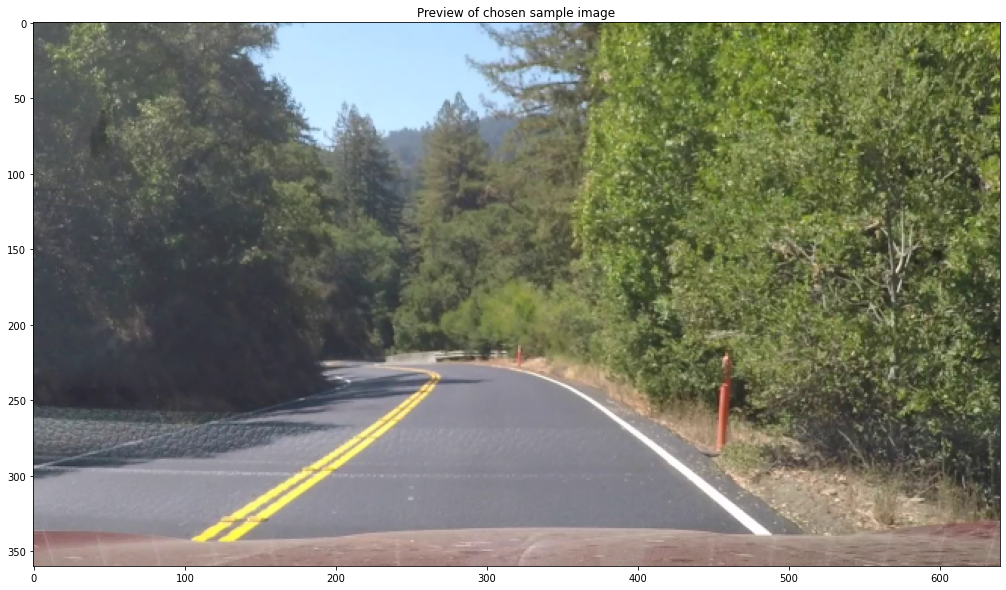

In [647]:
# test_image_BGR = macros.load_image("./assets/test_images/straight_lines1.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/straight_lines2.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test1.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test2.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test3.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test4.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test5.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test6.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_stream("./assets/project_video.mp4", (WIDTH, HEIGHT))[0]
# test_image_BGR = macros.load_stream("./assets/challenge_video.mp4", (WIDTH, HEIGHT))[0]
test_image_BGR = macros.load_stream("./assets/harder_challenge_video.mp4", (WIDTH, HEIGHT))[0]

# The following are extra samples for some tricky frames in the videos... Don't expect them to work!
# These frames are supposedly intermediate, so should be dealt with better through the iterative process...

# test_image_BGR = macros.load_image("./assets/test_images/test7.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test8.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test9.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test10.jpg", (WIDTH, HEIGHT))
# test_image_BGR = macros.load_image("./assets/test_images/test11.jpg", (WIDTH, HEIGHT))

test_image_RGB = cv2.cvtColor(test_image_BGR, cv2.COLOR_BGR2RGB)
macros.show(test_image_RGB, 'Preview of chosen sample image')


# Next, let's evaluate our channels #

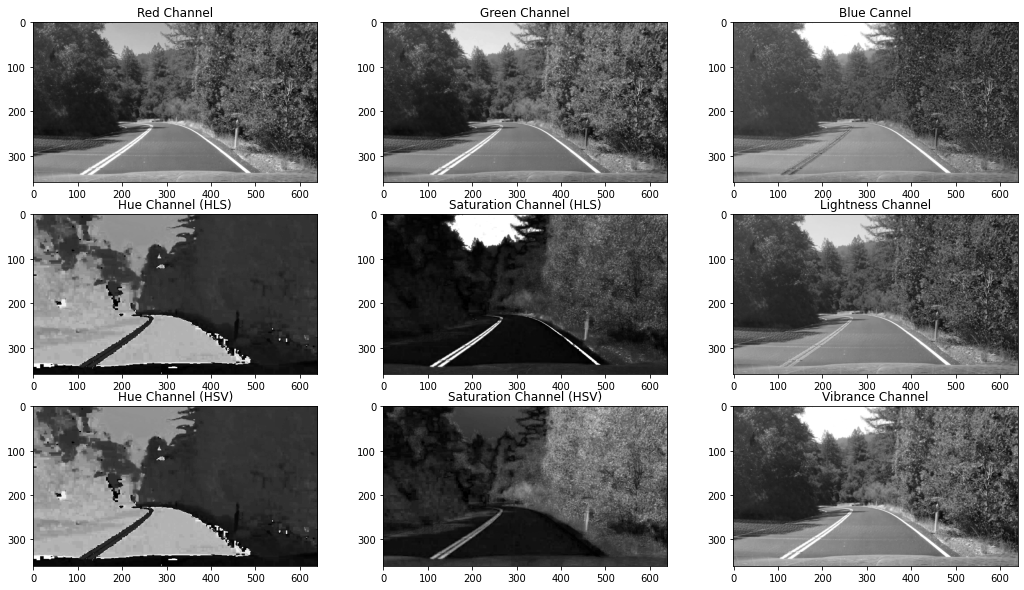

In [648]:
test_image_HLS = cv2.cvtColor(test_image_RGB, cv2.COLOR_RGB2HLS)
test_image_HSV = cv2.cvtColor(test_image_RGB, cv2.COLOR_RGB2HSV)

test_image_RGB_R = test_image_RGB[:, :, 0]
test_image_RGB_G = test_image_RGB[:, :, 1]
test_image_RGB_B = test_image_RGB[:, :, 2]

test_image_HLS_H = test_image_HLS[:, :, 0]
test_image_HLS_L = test_image_HLS[:, :, 1]
test_image_HLS_S = test_image_HLS[:, :, 2]

test_image_HSV_H = test_image_HSV[:, :, 0]
test_image_HSV_S = test_image_HSV[:, :, 1]
test_image_HSV_V = test_image_HSV[:, :, 2]

macros.grid_plot([

    [test_image_RGB_R, "Red Channel"],
    [test_image_RGB_G, "Green Channel"],
    [test_image_RGB_B, "Blue Cannel"],

    [test_image_HLS_H, "Hue Channel (HLS)"],
    [test_image_HLS_S, "Saturation Channel (HLS)"],
    [test_image_HLS_L, "Lightness Channel"],

    [test_image_HSV_H, "Hue Channel (HSV)"],
    [test_image_HSV_S, "Saturation Channel (HSV)"],
    [test_image_HSV_V, "Vibrance Channel"],

], rows=3)


# The S Channel from HLS seems to give best lane details #
But its L gives somewhat useful details too... HSV's V too... hmm, combine them?

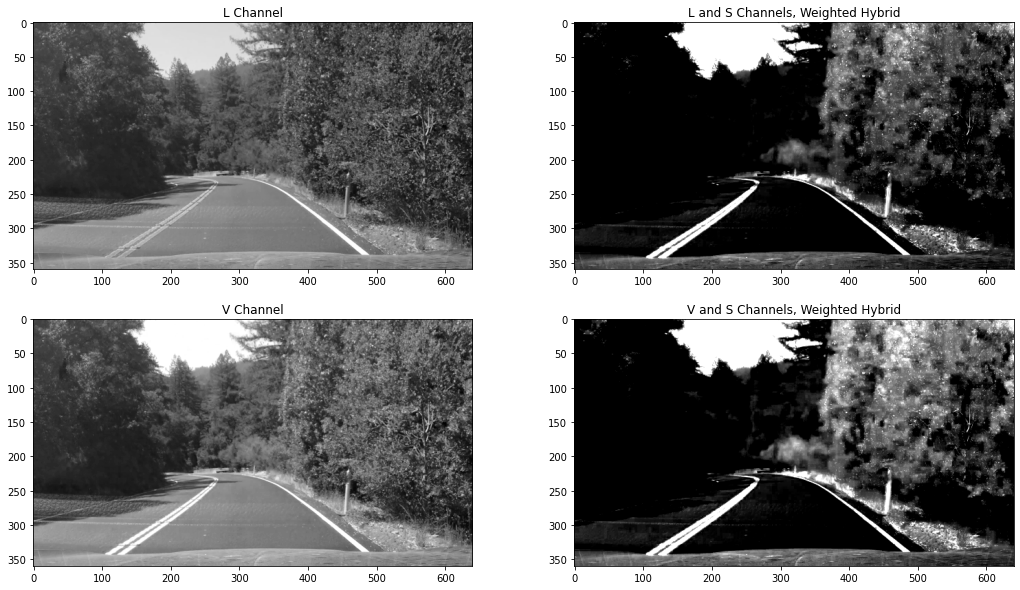

In [649]:
test_image_LS_hybrid = cv2.addWeighted(test_image_HLS_L, 1.5, test_image_HLS_S, 2.5, -255)
test_image_VS_hybrid = cv2.addWeighted(test_image_HSV_V, 1.5, test_image_HLS_S, 2.5, -255)

macros.grid_plot([

    [test_image_HLS_L, "L Channel"],
    [test_image_LS_hybrid, "L and S Channels, Weighted Hybrid"],
    [test_image_HSV_V, "V Channel"],
    [test_image_VS_hybrid, "V and S Channels, Weighted Hybrid"],

], rows=2)


# First, get the hood cutoff #

339


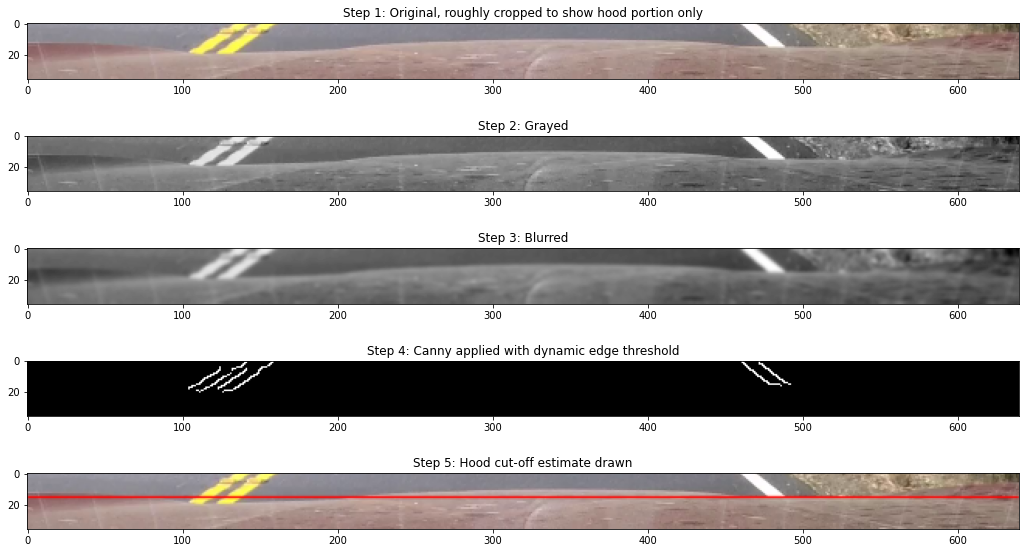

In [650]:

importlib.reload(salama_preprocessing_techniques)
HOODCUTOFF, steps = salama_preprocessing_techniques.get_hood_cutoff(test_image_BGR)
print(HOODCUTOFF)
macros.grid_plot(steps, vertical=True)


# Next, get the sky cutoff #
Here I try to find the strongest edges in the image that would signify the change from sky to road

[282, 223, 221] 242


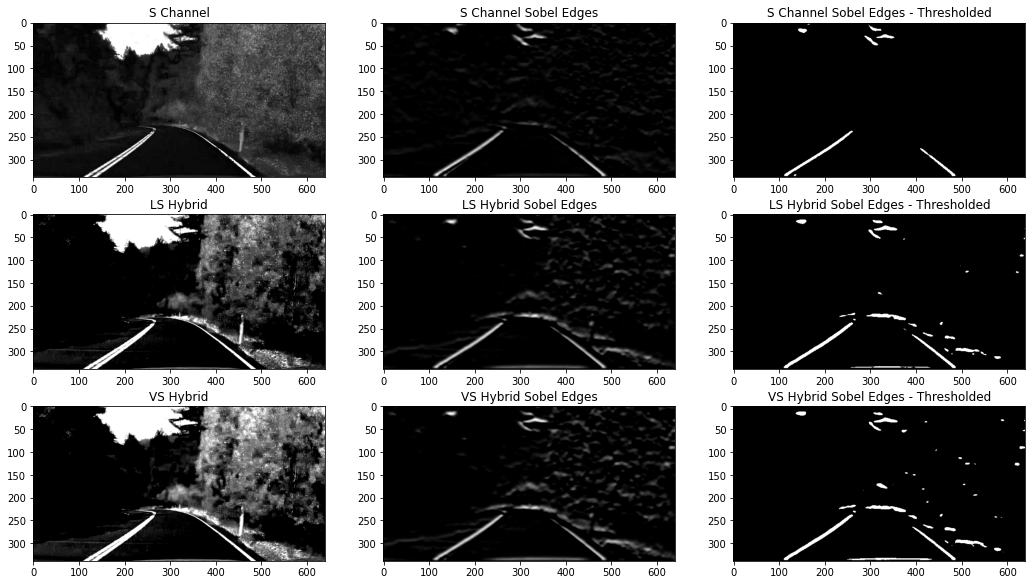

In [651]:

importlib.reload(salama_preprocessing_techniques)
SKYCUTOFF, cutoffs, steps = salama_preprocessing_techniques.get_sky_cutoff(test_image_BGR[:HOODCUTOFF])
print(cutoffs, SKYCUTOFF)
macros.grid_plot(steps, rows=3)


# And now display the final cutout #

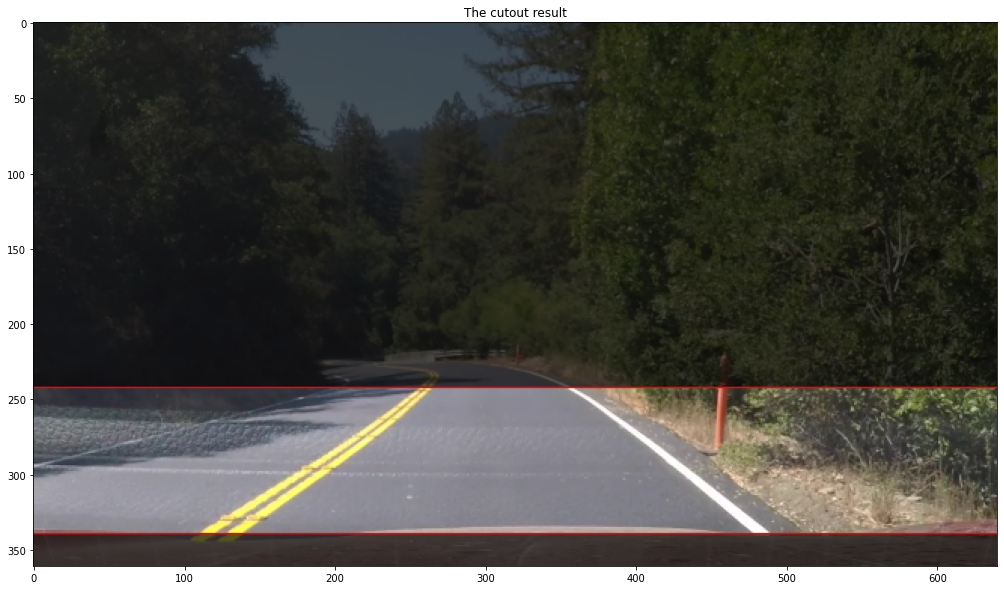

In [652]:
test_image_with_cutoffs = np.copy(test_image_RGB)
cv2.line(test_image_with_cutoffs, (0, HOODCUTOFF), (WIDTH - 1, HOODCUTOFF), (255, 0, 0), 1)
cv2.line(test_image_with_cutoffs, (0, SKYCUTOFF), (WIDTH - 1, SKYCUTOFF), (255, 0, 0), 1)
macros.show(

    cv2.vconcat([

        test_image_RGB[:SKYCUTOFF] // 3,
        test_image_with_cutoffs[SKYCUTOFF:HOODCUTOFF + 1],
        test_image_RGB[HOODCUTOFF:] // 3

    ]),

    "The cutout result"

)


# Maybe use the fact that lanes are either yellow or white? #
We don't need any colors other than those (for lane detection), so why not remove everything else?

Let's try two color spaces, HLS and CIELab; which supposedly isolate colors from lightness so should help detecting raw yellows

#### First, some calibration ####

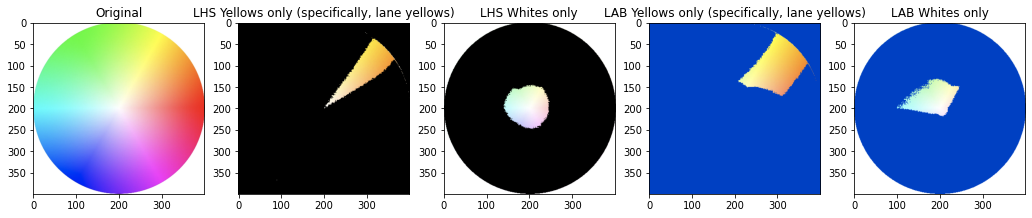

In [653]:
importlib.reload(salama_preprocessing_techniques)

color_wheel_BGR = macros.load_image("./assets/color_wheel_for_calibration.png")

_, _, LHS_threshold_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(color_wheel_BGR,
                                                                salama_preprocessing_techniques.HLS_COLORSPACE_THRESH)

_, _, LAB_threshold_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(color_wheel_BGR,
                                                                salama_preprocessing_techniques.LAB_COLORSPACE_THRESH)

macros.grid_plot([

    [cv2.cvtColor(color_wheel_BGR, cv2.COLOR_BGR2RGB), "Original"],
    [cv2.cvtColor(LHS_threshold_steps[0], cv2.COLOR_HLS2RGB), "LHS Yellows only (specifically, lane yellows)"],
    [cv2.cvtColor(LHS_threshold_steps[1], cv2.COLOR_HLS2RGB), "LHS Whites only"],
    [cv2.cvtColor(LAB_threshold_steps[0], cv2.COLOR_LAB2RGB), "LAB Yellows only (specifically, lane yellows)"],
    [cv2.cvtColor(LAB_threshold_steps[1], cv2.COLOR_LAB2RGB), "LAB Whites only"],

])


#### And now the technique in use ####

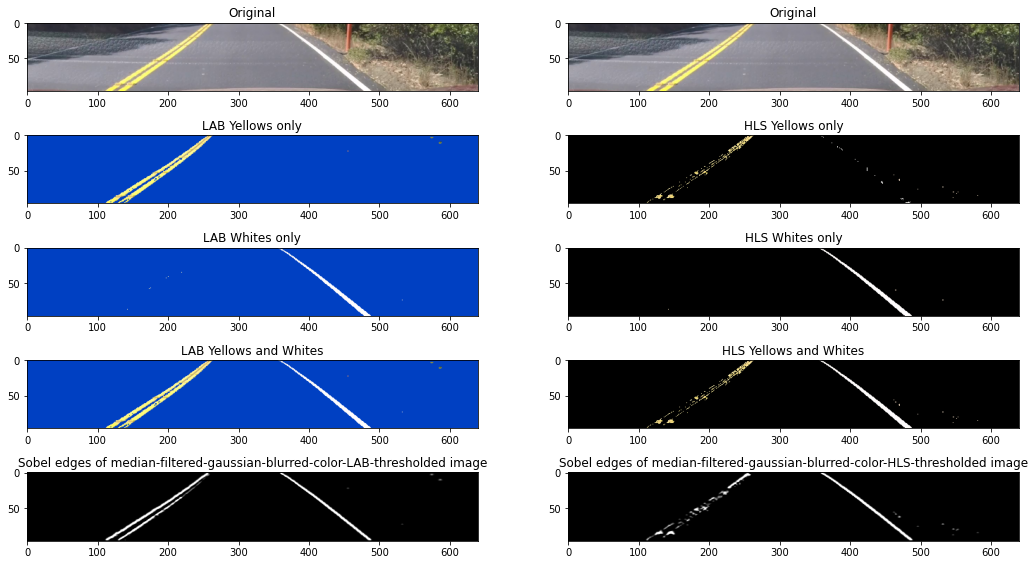

In [654]:
importlib.reload(salama_preprocessing_techniques)

HLS_color_thresholded_canny, HLS_color_thresholded_frame, HLS_color_thresholding_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF],
                                                                salama_preprocessing_techniques.HLS_COLORSPACE_THRESH)

LAB_color_thresholded_canny, LAB_color_thresholded_frame, LAB_color_thresholding_steps = \
    salama_preprocessing_techniques.color_thresholded_edges_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF],
                                                                salama_preprocessing_techniques.LAB_COLORSPACE_THRESH)

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],

    [cv2.cvtColor(LAB_color_thresholding_steps[0], cv2.COLOR_LAB2RGB), "LAB Yellows only"],
    [cv2.cvtColor(HLS_color_thresholding_steps[0], cv2.COLOR_HLS2RGB), "HLS Yellows only"],

    [cv2.cvtColor(LAB_color_thresholding_steps[1], cv2.COLOR_LAB2RGB), "LAB Whites only"],
    [cv2.cvtColor(HLS_color_thresholding_steps[1], cv2.COLOR_HLS2RGB), "HLS Whites only"],

    [cv2.cvtColor(LAB_color_thresholded_frame, cv2.COLOR_LAB2RGB), "LAB Yellows and Whites"],
    [cv2.cvtColor(HLS_color_thresholded_frame, cv2.COLOR_HLS2RGB), "HLS Yellows and Whites"],

    [LAB_color_thresholded_canny, "Sobel edges of median-filtered-gaussian-blurred-color-LAB-thresholded image"],
    [HLS_color_thresholded_canny, "Sobel edges of median-filtered-gaussian-blurred-color-HLS-thresholded image"]

], rows=5)


# What about adaptive thresholding? #

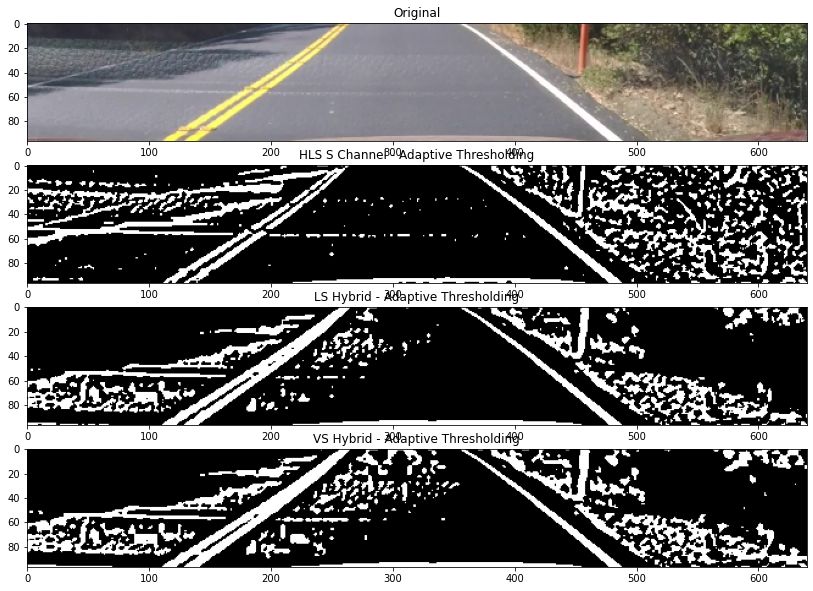

In [655]:
importlib.reload(salama_preprocessing_techniques)

test_image_HLS_S_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_HLS_L[SKYCUTOFF:HOODCUTOFF])

test_image_LS_hybrid_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF])

test_image_VS_hybrid_thresholded_adaptive =\
    salama_preprocessing_techniques.adaptive_thresholding_pre(test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_HLS_S_thresholded_adaptive, "HLS S Channel - Adaptive Thresholding"],
    [test_image_LS_hybrid_thresholded_adaptive, "LS Hybrid - Adaptive Thresholding"],
    [test_image_VS_hybrid_thresholded_adaptive, "VS Hybrid - Adaptive Thresholding"],

], vertical=True)


# The Sobels #

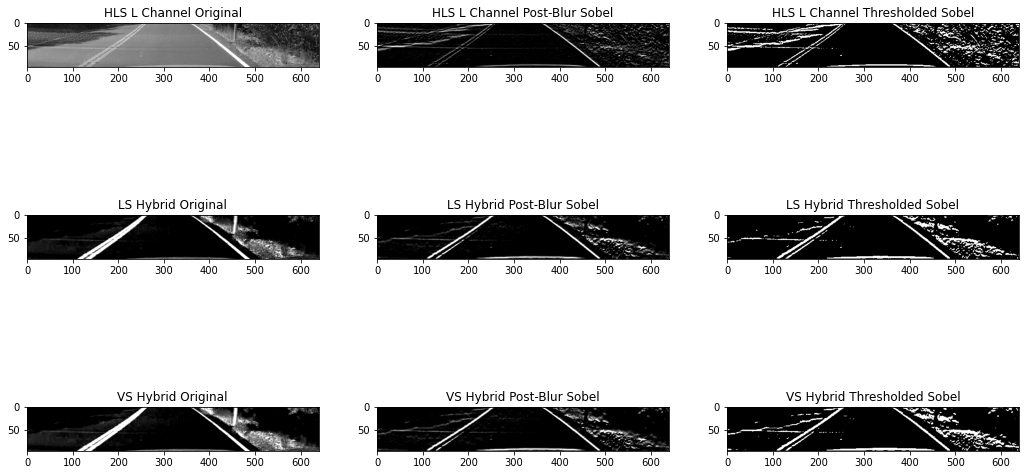

In [656]:
importlib.reload(salama_preprocessing_techniques)

test_image_HLS_L_sobel_thresh, test_image_HLS_L_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_HLS_L[SKYCUTOFF:HOODCUTOFF], (1, 3), (50, 150))

test_image_LS_hybrid_sobel_thresh, test_image_LS_hybrid_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF], (1, 5), (50, 150))

test_image_VS_hybrid_sobel_thresh, test_image_VS_hybrid_sobel_raw =\
    salama_preprocessing_techniques.sobel_pre(test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF], (1, 5), (50, 150))

macros.grid_plot([

    [test_image_HLS_L[SKYCUTOFF:HOODCUTOFF], "HLS L Channel Original"],
    [test_image_HLS_L_sobel_raw, "HLS L Channel Post-Blur Sobel"],
    [test_image_HLS_L_sobel_thresh, "HLS L Channel Thresholded Sobel"],

    [test_image_LS_hybrid[SKYCUTOFF:HOODCUTOFF], "LS Hybrid Original"],
    [test_image_LS_hybrid_sobel_raw, "LS Hybrid Post-Blur Sobel"],
    [test_image_LS_hybrid_sobel_thresh, "LS Hybrid Thresholded Sobel"],

    [test_image_VS_hybrid[SKYCUTOFF:HOODCUTOFF], "VS Hybrid Original"],
    [test_image_VS_hybrid_sobel_raw, "VS Hybrid Post-Blur Sobel"],
    [test_image_VS_hybrid_sobel_thresh, "VS Hybrid Thresholded Sobel"],

], rows=3)


# "Top/white hat" transform? #
Should supposedly bring out the details of any white object atop of any black

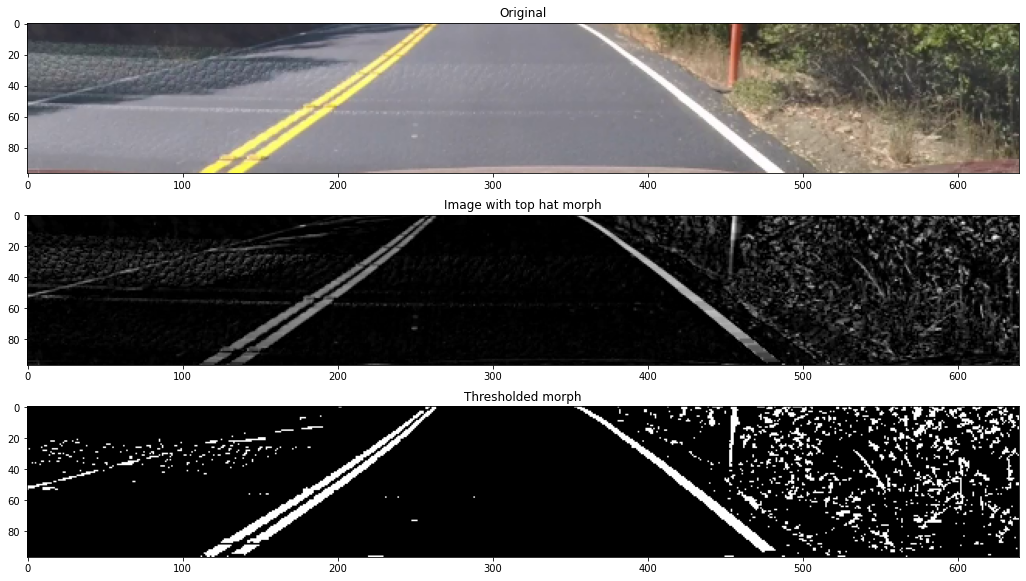

In [657]:
importlib.reload(salama_preprocessing_techniques)

test_image_TOPHAT_thresholded, test_image_TOPHAT =\
    salama_preprocessing_techniques.morph_top_hat_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [test_image_TOPHAT, "Image with top hat morph"],
    [test_image_TOPHAT_thresholded, "Thresholded morph"]

], vertical=True)


# How about, inverse black hat? #
Black hat works opposite to white/top hat... How about use it to *remove* noise?

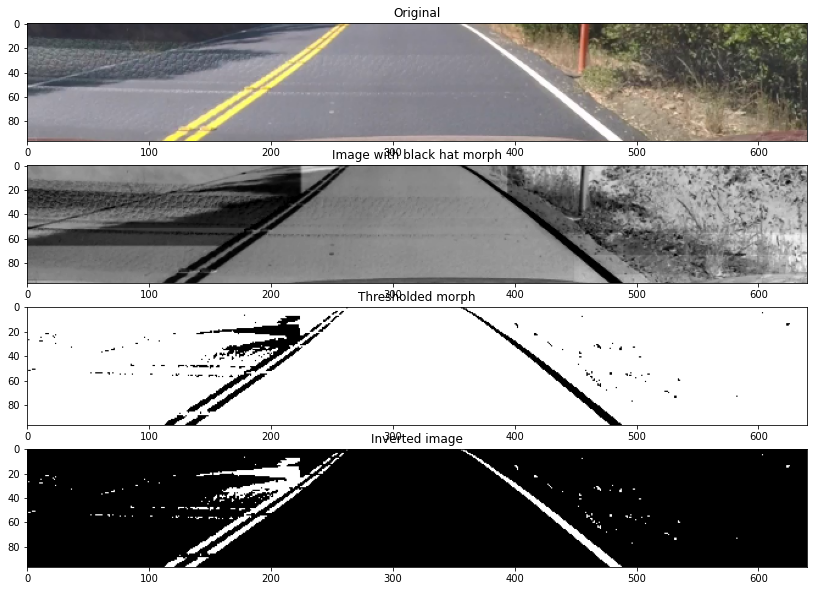

In [658]:
importlib.reload(salama_preprocessing_techniques)

image_inv_BLACKHAT_thresholded, image_BLACKHAT_thresholded, image_BLACKHAT =\
    salama_preprocessing_techniques.morph_inv_black_hat_pre(test_image_BGR[SKYCUTOFF:HOODCUTOFF])

macros.grid_plot([

    [test_image_RGB[SKYCUTOFF:HOODCUTOFF], "Original"],
    [image_BLACKHAT, "Image with black hat morph"],
    [image_BLACKHAT_thresholded, "Thresholded morph"],
    [image_inv_BLACKHAT_thresholded, "Inverted image"]

], vertical=True)


# Canny then Hough transform? #
This works best provided an arbitrary/hard-coded ROI...

I am trying to avoid this though; but this bounds the Hough transform algorithm for failure due to excessive noise

It would probably be better to try the Hough transform *after* voting ensemble to detect the lines afterwards

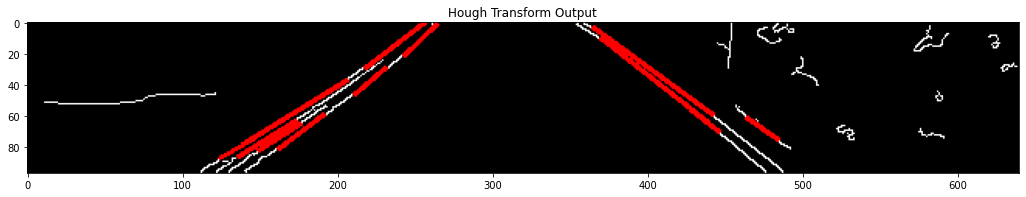

In [659]:
importlib.reload(salama_preprocessing_techniques)

raw_canny =\
    salama_preprocessing_techniques.canny_raw_pre(
        cv2.cvtColor(test_image_BGR[SKYCUTOFF:HOODCUTOFF], cv2.COLOR_BGR2GRAY))

edges_detected\
    = salama_preprocessing_techniques.hough_transform_raw_pre(raw_canny)

raw_canny_canvas = cv2.cvtColor(raw_canny, cv2.COLOR_GRAY2RGB)  # converting so I can draw red on it

if (edges_detected.any() != None):
    for edge in edges_detected:
        cv2.line(raw_canny_canvas,
                 (edge[0][0], edge[0][1]),
                 (edge[0][2], edge[0][3]),
                 (255, 0, 0),
                 2)

    macros.show(raw_canny_canvas, "Hough Transform Output")


# How about all of them? #
#### Can perform a voting ensemble on: ####
- Color-Thresholded Canny (HLS and LAB)
- Channel Adaptive Threshold (S, LS, VS)
- Channel-Thresholded Sobels (S, LS, VS)
- Top (White) Hat Morph
- Inverted Black Hat Morph
- Raw Canny

#### Followed by: ####
- Probabilistic Hough Transform

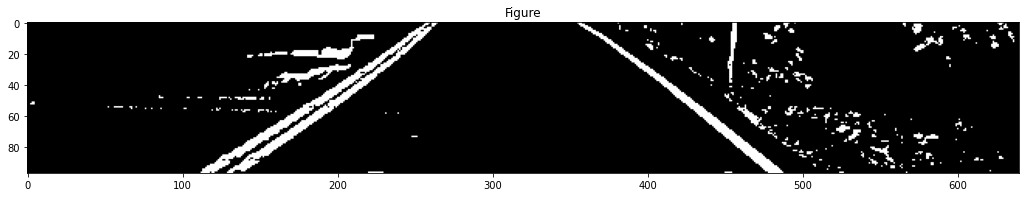

In [660]:
importlib.reload(salama_preprocessing_techniques)
voting_ensemble_result = salama_preprocessing_techniques.edge_voting_ensemble([

    HLS_color_thresholded_canny,
    LAB_color_thresholded_canny,
    test_image_HLS_S_thresholded_adaptive,
    test_image_LS_hybrid_thresholded_adaptive,
    test_image_VS_hybrid_thresholded_adaptive,
    test_image_HLS_L_sobel_thresh,
    test_image_LS_hybrid_sobel_thresh,
    test_image_VS_hybrid_sobel_thresh,
    test_image_TOPHAT_thresholded,
    image_inv_BLACKHAT_thresholded,
    raw_canny,

], 4)

macros.show(voting_ensemble_result)


# Hough, again? #
This time applied on the result of the voting ensemble

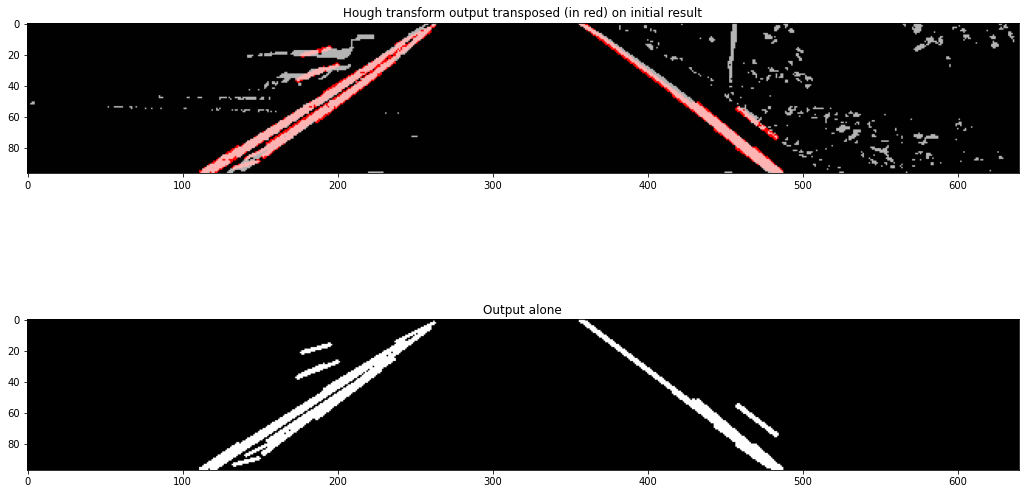

In [661]:
importlib.reload(salama_preprocessing_techniques)

voting_ensemble_edges = salama_preprocessing_techniques.hough_transform_raw_pre(voting_ensemble_result)

voting_ensemble_edges_canvas = np.zeros_like(voting_ensemble_result)

try:
    for edge in voting_ensemble_edges:
        cv2.line(voting_ensemble_edges_canvas,
                 (edge[0][0], edge[0][1]),
                 (edge[0][2], edge[0][3]),
                 255,
                 2)

    voting_ensemble_edges_canvas_red = cv2.cvtColor(voting_ensemble_edges_canvas, cv2.COLOR_GRAY2RGB)
    voting_ensemble_edges_canvas_red[:, :, 1] = 0
    voting_ensemble_edges_canvas_red[:, :, 2] = 0

    macros.grid_plot([

        [cv2.addWeighted(voting_ensemble_edges_canvas_red, 1,
                         cv2.cvtColor(voting_ensemble_result, cv2.COLOR_GRAY2RGB), 0.7,
                         1), "Hough transform output transposed (in red) on initial result"],
        [voting_ensemble_edges_canvas, "Output alone"],

    ], vertical=True)

except: raise("No edges found with this voting threshold! Try lowering it...")

# Well then, moment of truth! #

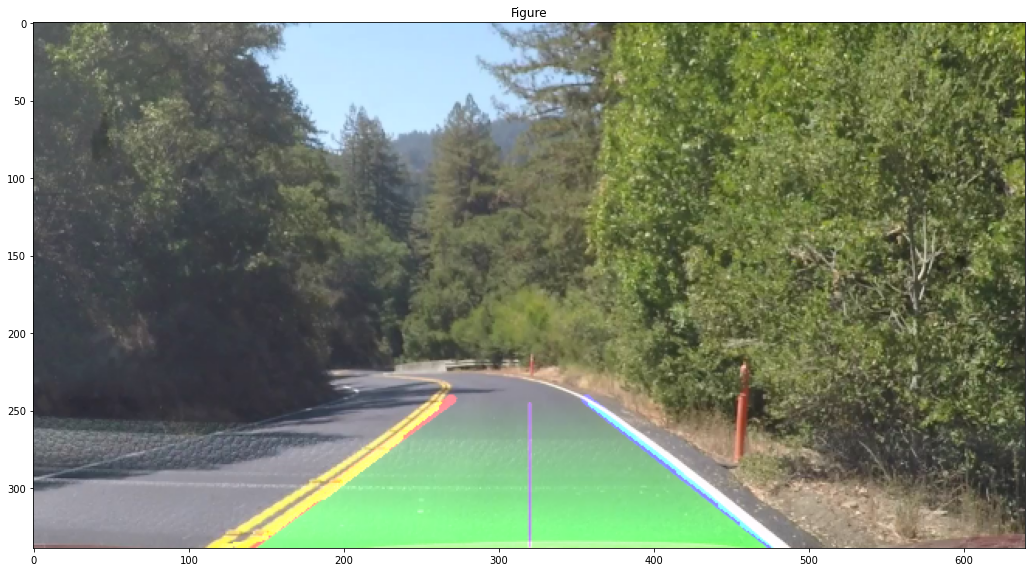

In [662]:
importlib.reload(salama_preprocessing_techniques)
importlib.reload(salama_lane_detection_algorithm)

ready_for_lane_detection = np.copy(voting_ensemble_edges_canvas)

# Extract lane data (ld) with 1st order peeking center detection algorithm
ld = salama_lane_detection_algorithm.peeking_center_detect(ready_for_lane_detection, 1)
lane = ld.draw(test_image_BGR, SKYCUTOFF, HOODCUTOFF, debugging=True)

macros.show(cv2.addWeighted(cv2.vconcat([
                                test_image_RGB[:SKYCUTOFF],
                                test_image_RGB[SKYCUTOFF:HOODCUTOFF],
                                # np.zeros_like(test_image_RGB[SKYCUTOFF:HOODCUTOFF]),
                                # cv2.cvtColor(ready_for_lane_detection, cv2.COLOR_GRAY2BGR),
                            ]), 1,
                            lane, 1, 0))


# Now, the actual pipeline #

In [663]:
importlib.reload(pipeline)
# run pipeline
# provide args
# pipeline.run_pipeline(WIDTH//5, HEIGHT//5, "./assets/project_video.mp4", f"./out/demo")


<module 'pipeline' from 'g:\\#_College\\#semester_8_spring\\CSE483 Computer Vision\\Project\\asufecse483project-simpleperceptionstack\\pipeline.py'>